In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import sys
from pathlib import Path
sys.path.insert(0, str(Path().resolve().parents[1]))
from model import plot_style

In [2]:
import seaborn as sns
import compactletterdisplay as cld
import pandas as pd

In [3]:
import os
os.getcwd()

'c:\\Users\\caele\\Desktop\\Spring2025\\miller-lab-final\\figures\\figure8'

In [ ]:
CVs = [0.05, 0.5, 1, 1.75]
data_dir = 'data'
raw_reliabilities = [[np.load(f"{data_dir}/raw_reliabilities/CV_{cv:.2f}/reliabilities_{i+1}.npy") for i in range(10)] for cv in CVs]
zero_reliabilities = [np.load(f"{data_dir}/raw_reliabilities/CV_{0:.2f}/reliabilities_{2}.npy")] * 10
raw_reliabilities.insert(0, zero_reliabilities)

longest_paths = [[np.load(f"{data_dir}/longest_paths_1/CV_{cv:.2f}/longest_paths_{i+1}.npy") for i in range(10)] for cv in CVs]
zero_path = [np.load(f"{data_dir}/longest_paths_1/CV_{0:.2f}/longest_paths_{2}.npy")] * 10
longest_paths.insert(0, zero_path)

CVs.insert(0, 0.0)

In [5]:
max_reliabilities = np.array([np.max(reliabilities) for cv_reliabilities in raw_reliabilities for reliabilities in cv_reliabilities]).reshape(len(CVs), -1)
area_over_baseline = np.array([np.sum(reliabilities > 0.73)/len(reliabilities.flatten()) for cv_reliabilities in raw_reliabilities for reliabilities in cv_reliabilities]).reshape(len(CVs), -1)
mean_reliabilities = np.array([np.mean(reliabilities) for cv_reliabilities in raw_reliabilities for reliabilities in cv_reliabilities]).reshape(len(CVs), -1)

In [6]:
mean_longest_paths = np.array([np.mean(longest_path) for cv_longest_path in longest_paths for longest_path in cv_longest_path]).reshape(len(CVs), -1)
max_longest_paths = np.array([np.max(longest_path) for cv_longest_path in longest_paths for longest_path in cv_longest_path]).reshape(len(CVs), -1)

In [7]:
state_counts = np.load(f"{data_dir}/state_counts/state_counts.npy")
state_counts.shape, state_counts[0]

((40, 3), array([ 1.  ,  0.05, 32.  ]))

In [8]:
state_counts = np.vstack([np.array([32]*10), state_counts[:, 2].reshape((4,10))]) # fix

In [9]:
from matplotlib.ticker import FormatStrFormatter

C:\Users\caele\AppData\Local\Temp\ipykernel_25652\357539343.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'${cv:.2f}$' for cv in CVs], rotation=45)


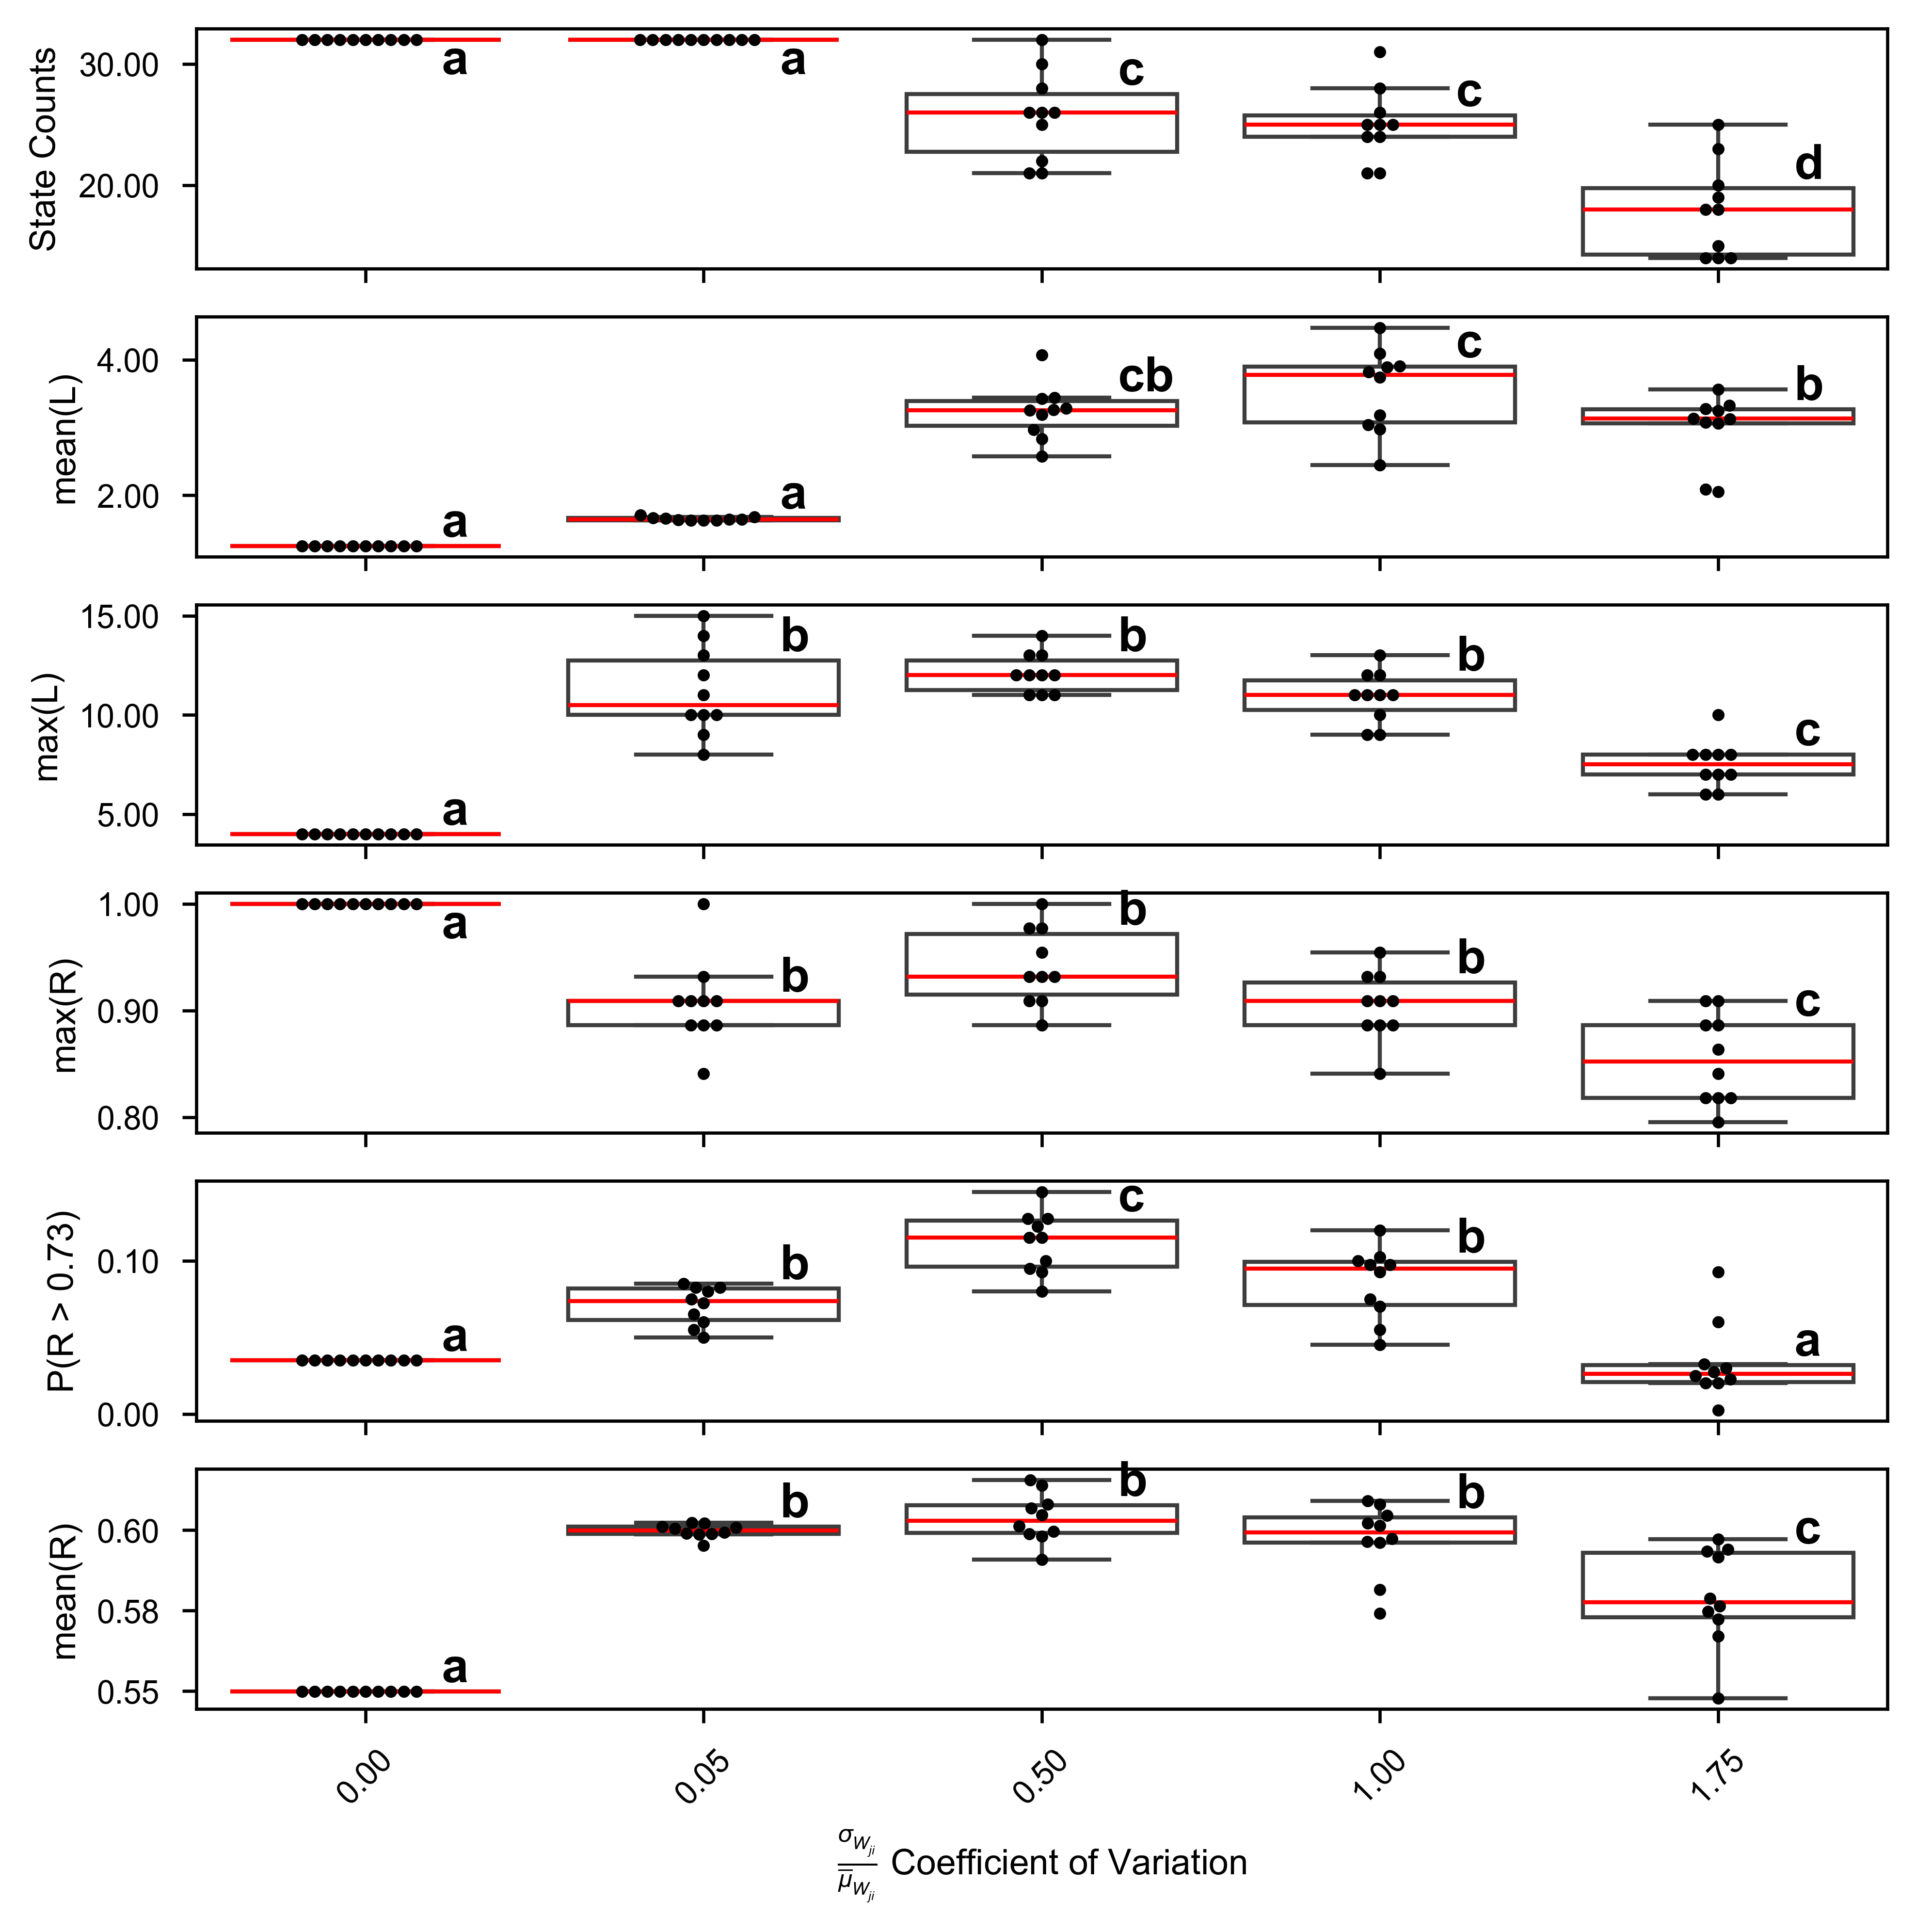

In [10]:
MIN_WIDTH = 1578    # in pixels at 600 dpi
MAX_WIDTH = 4500
MAX_HEIGHT = 5250

px = 1/plt.rcParams['figure.dpi']   # convert pixel to inches
fig, axs = plt.subplots(6, 1, figsize=(MAX_WIDTH*px, MAX_WIDTH*px), sharex=True)
data = [state_counts, mean_longest_paths, max_longest_paths, max_reliabilities, area_over_baseline, mean_reliabilities]
y_labels = ['State Counts', 'mean(L)', 'max(L)', 'max(R)', 'P(R > 0.73)', 'mean(R)']
alpha = 0.05 / math.comb(len(CVs), 2)  # Bonferroni correction for multiple comparisons
for i, ax in enumerate(axs):
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    if i == 5:
        ax.set_xticklabels([f'${cv:.2f}$' for cv in CVs], rotation=45)
        ax.set_xlabel(r"$\frac{\sigma_{W_{ji}}}{\overline{\mu}_{W_{ji}}}$" + " Coefficient of Variation")
    if not y_labels[i]:
        continue
    values = np.array(data[i])
    sns.swarmplot(data=values.T, ax=ax, color='black', size=3)
    sns.boxplot(data=values.T, ax=ax, color='white', showfliers=False, medianprops={'color': 'red'})
    cld_result = cld.anova_cld(pd.DataFrame(values.T, columns=CVs), CVs, alpha=alpha)
    ax.set_ylabel(y_labels[i])
    for i, cv in enumerate(CVs):
        letter = cld_result[cld_result['Group'] == cv]['CLD'].values[0]
        Q3 = np.percentile(values.T[:, i], 75)
        v_offset = 0 if Q3 < np.max(values) else -0.2 * (np.max(values) - np.min(values))
        h_offset = 0.225
        ax.text(i + h_offset, Q3 + v_offset, letter, ha='left', va='bottom', fontweight='bold')

C:\Users\caele\AppData\Local\Temp\ipykernel_25652\2414709921.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'$10e{cv:.2f}$' for cv in np.linspace(-1, 0, 5)])


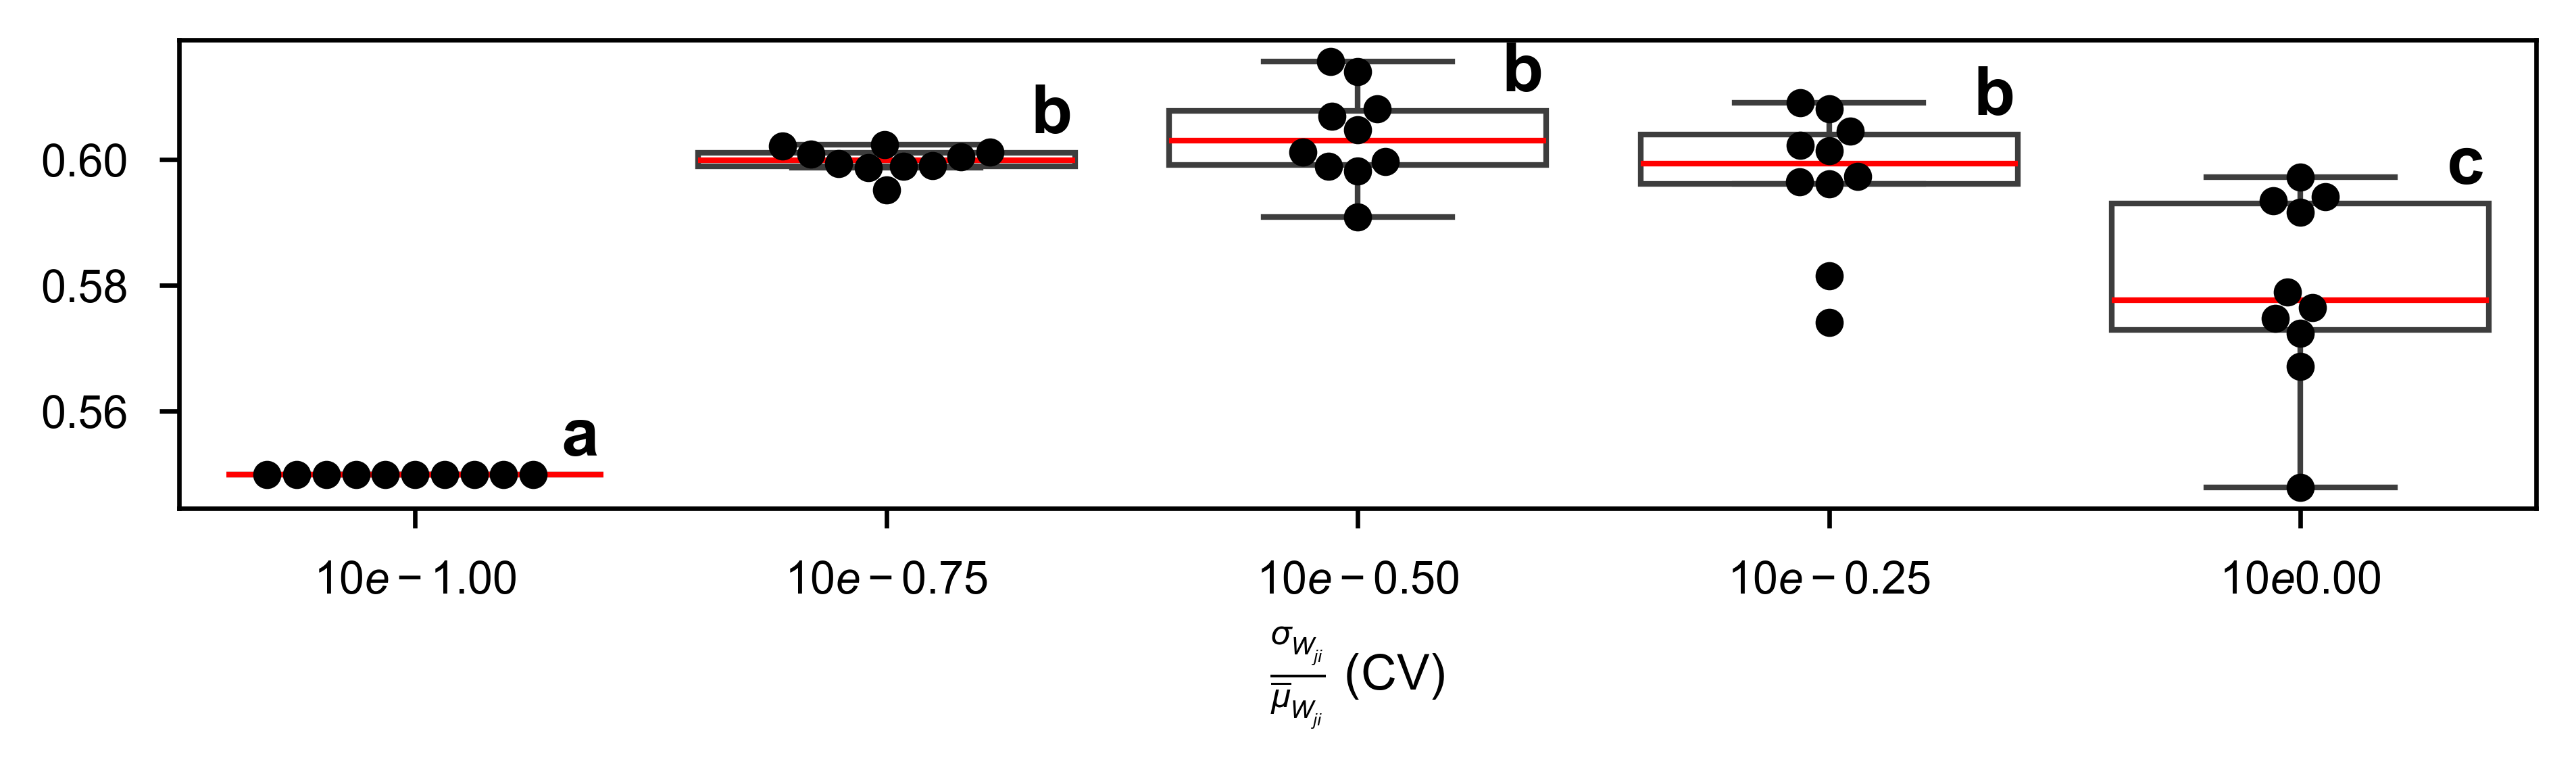

In [11]:
# swarmplot of mean_reliabilities
fig,ax = plt.subplots(figsize=(MAX_WIDTH*px, MAX_WIDTH*0.2*px))
sns.swarmplot(data=mean_reliabilities.T, ax=ax, color='black')
sns.boxplot(data=mean_reliabilities.T, ax=ax, color='white', showfliers=False, medianprops={'color': 'red'})
ax.set_xticklabels([f'$10e{cv:.2f}$' for cv in np.linspace(-1, 0, 5)])
ax.set_xlabel(r"$\frac{\sigma_{W_{ji}}}{\overline{\mu}_{W_{ji}}}$" + " (CV)")
cld_result = cld.anova_cld(pd.DataFrame(mean_reliabilities.T, columns=CVs), CVs, alpha=0.05)
for i, cv in enumerate(CVs):
    letter = cld_result[cld_result['Group'] == cv]['CLD'].values[0]
    Q3 = np.percentile(mean_reliabilities.T[:, i], 75)
    v_offset = 0.015 * (np.max(mean_reliabilities) - np.min(mean_reliabilities))
    h_offset = 0.35
    ax.text(i + h_offset, Q3 + v_offset, letter, ha='center', va='bottom', fontweight='bold')

In [12]:
cld_result

,Group,Mean,CLD
0,0.00,0.549830,a
1,0.05,0.599795,b
2,0.50,0.603801,b
3,1.00,0.597062,b
4,1.75,0.579364,c


[14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 34, 24, 29, 33, 30, 22, 33, 20, 32, 26, 51, 51, 58, 37, 32, 49, 46, 46, 40, 38, 48, 39, 28, 18, 22, 40, 30, 41, 37, 39, 8, 24, 8, 9, 10, 13, 12, 11, 1, 37]


Text(0.5, 1.0, 'Max Reliability vs CV')

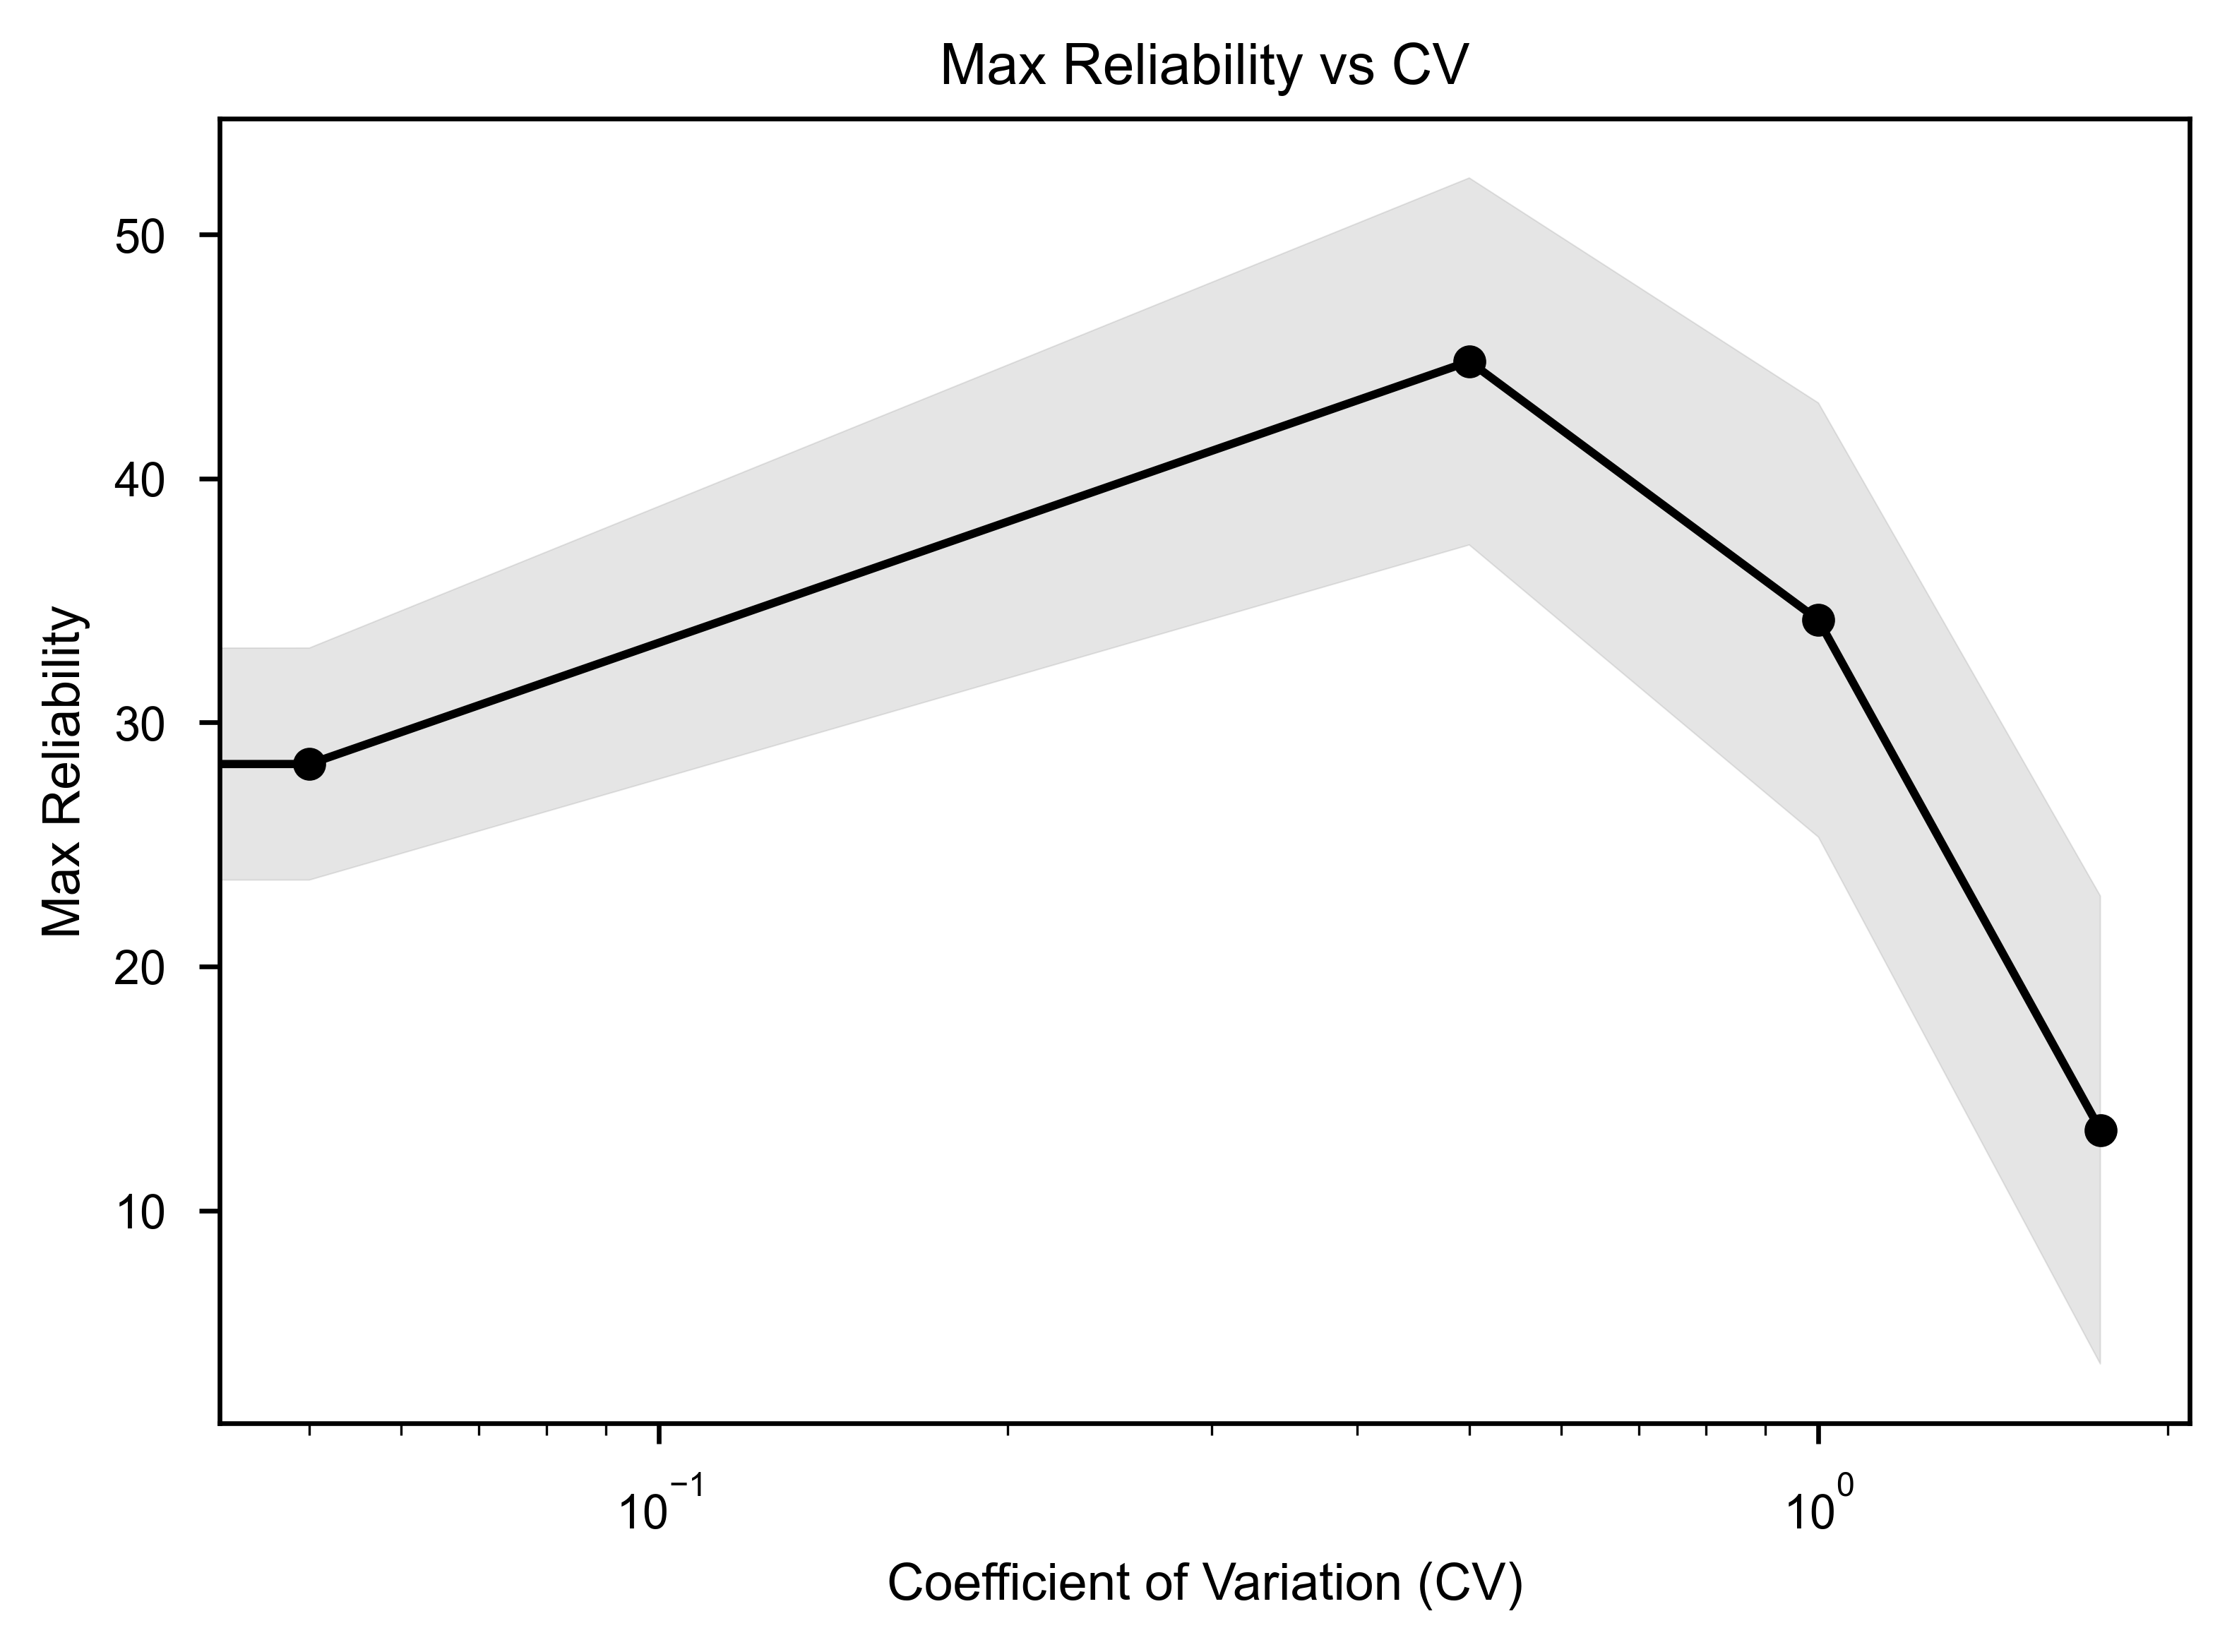

In [13]:
area_over_baseline = [np.sum(reliabilities>0.73) for cv_reliabilities in raw_reliabilities for reliabilities in cv_reliabilities]
print(area_over_baseline)
area_over_baseline = np.array(area_over_baseline).reshape(len(CVs), 10)
plt.figure(figsize=(6, 4))
plt.plot(CVs, area_over_baseline.mean(axis=1), marker='o', color='black', label='Mean Max Reliability')
# stdev
plt.fill_between(CVs, area_over_baseline.mean(axis=1) - area_over_baseline.std(axis=1), 
                 area_over_baseline.mean(axis=1) + area_over_baseline.std(axis=1), 
                 color='gray', alpha=0.2, label='Standard Deviation')
plt.xscale('log')
plt.xlabel('Coefficient of Variation (CV)')
plt.ylabel('Max Reliability')
plt.title('Max Reliability vs CV')
